In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter('ignore')

**<h2 style="color:#0d1a75">Import Data</h2>**

In [ ]:
TARIN_PATH = '/kaggle/input/tabular-playground-series-may-2022/train.csv'
TEST_PATH = '/kaggle/input/tabular-playground-series-may-2022/test.csv'

train_df = pd.read_csv(TARIN_PATH)
test_df = pd.read_csv(TEST_PATH)

train_df['train_test'] = 1
test_df['train_test'] = 0
test_df['target'] = np.NaN

df = pd.concat((train_df, test_df), axis=0)

In [ ]:
train_df.describe()

In [ ]:
train_df.info()

In [ ]:
df.f_27.nunique()

## Many levels Categorical Variable:
> <font size=3>We have f_27 has **(1181880)** unique values, so we can not use one_hot_encoder to convert this feature to numerical values as it will leads to marvelous number of features will cause overfit </br> So we need to handle this categorical feature with another method.</font>

> <font size=3>We can group this feature according to another variable (according to Practical Statistics for Data Scientists book), we will use residuals form initial model to encode this feature</font>

## Steps of Encoding:
> <font size=3><a href='#initial model'>1. Create initial model</a></br>
<a href='#residuals'>2. Calculate residual of this model.</a></br>
<a href='#grouping'>3. Group f_27.</a></font>

<a id='initial model'>
<h2 name='initial model', style='color:#0d1a75';>Create initial model</h2></a>

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
OE = OrdinalEncoder()
df['f_27_en'] = OE.fit_transform(df['f_27'].values.reshape(-1, 1))
X_columns = df.columns.drop(['train_test', 'target', 'id', 'f_27'])
X_train = df.loc[df.train_test==1, X_columns]
y_train = df.loc[df.train_test==1, 'target']

In [ ]:
LR_model = LinearRegression(n_jobs=-1)
LR_model.fit(X_train, y_train)
LR_model.score(X_train, y_train)

<a id='residuals'>
<h2 style='color:#0d1a75';>Calculate residuals of model</h2></a>

In [ ]:
y_pred = LR_model.predict(X_train)
residuals = y_pred - y_train

<a id='grouping'>
<h2 style='color:#0d1a75';>Group f_27</h2></a>

In [ ]:
group_df = pd.DataFrame({'f_27':df.loc[df.train_test==1, 'f_27'], 'residual':residuals})
group_df = group_df.groupby('f_27').median()
group_df['groups'] = pd.qcut(group_df.values.reshape(-1, ), 5, labels=False)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
plt.suptitle('Ditribution of residuals in each f_27 group', size=5)
for idx, ax in enumerate(axs.flatten()):
    sns.distplot(group_df.loc[group_df.groups==idx, 'residual'], ax=ax)
    ax.set_title(f"Group No. {idx + 1}", size=3)

In [ ]:
df = df.join(group_df, on='f_27')

fig, axs = plt.subplots(2, 3, figsize=(20, 12))
for idx, ax in enumerate(axs.flatten()):
    sns.distplot(df.loc[df.groups==idx, 'target'], ax=ax)
    ax.set_title(f"Group No. {idx + 1}")

In [ ]:
plt.style.use('ggplot')
plt.subplots(figsize=(20, 4))
plt.title('Count of each f_27 Group', size=20)
plt.ylabel('Count', size=20)
plt.xlabel('Groups', size=20)
sns.countplot(df.groups);

In [ ]:
null_percentage = df.loc[df.train_test==0, 'groups'].isnull().sum() / test_df.shape[0] * 100
print(f'Percentage of nulls in groups in test data = {null_percentage} %')

<font size=4, style="color:#0d1a75;">We notice that there are much nulls in test data, which means most of f_27 values in test data is not provided in train data, **So this method may not be usefull in this case.**</font>

<h2 style="color:#0d1a75;">Reference:</h2>
<font size=3>1. Peter Bruce, Andrew Bruce, Peter Gedeck. <strong>Practical Statistics for Data Scientists</strong></font>

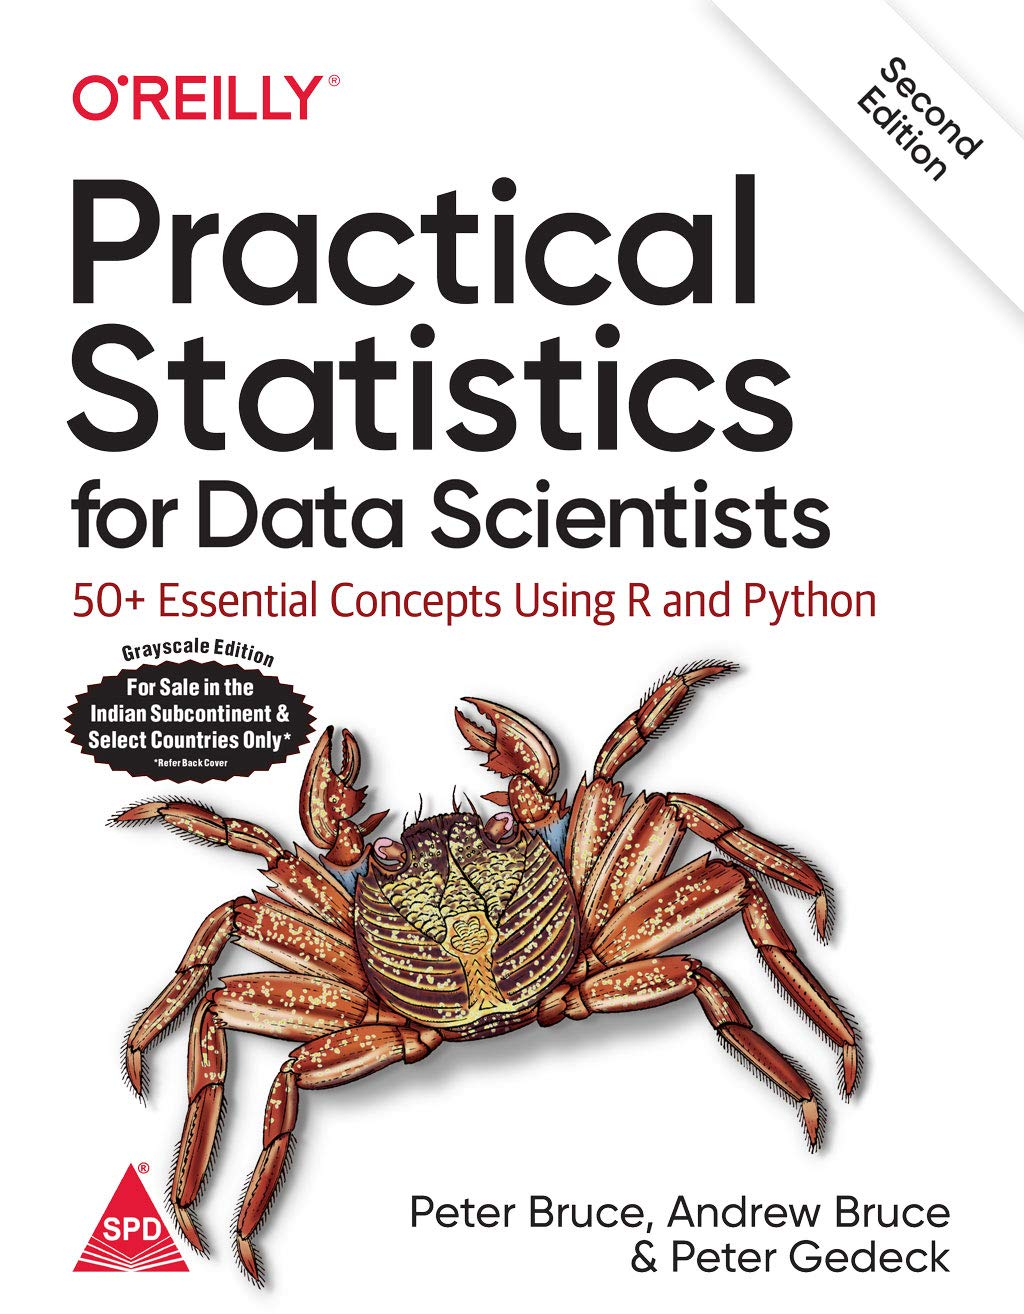